In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Load standardized data

In [28]:
X_scaled_df = pd.read_csv('../dataset/user_scaled.csv')
print(X_scaled_df.skew())
cols_to_use = ['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']
X_final = X_scaled_df[cols_to_use]

Unnamed: 0         0.000000
Recency            0.095433
Frequency          1.370417
Monetary           0.022708
Conversion_Rate    0.045108
dtype: float64


## 2.PCA projection

In [29]:
# Giữ lại 95% thông tin
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_final)

# 3. Kiểm tra lại kết quả
print(f"Số lượng PC giữ lại: {pca.n_components_}")
print(f"Tỷ lệ phương sai giải thích: {pca.explained_variance_ratio_}")
print(f"Tổng thông tin giữ lại: {sum(pca.explained_variance_ratio_):.2f}")


Số lượng PC giữ lại: 4
Tỷ lệ phương sai giải thích: [0.33720503 0.26570233 0.2285064  0.16858624]
Tổng thông tin giữ lại: 1.00


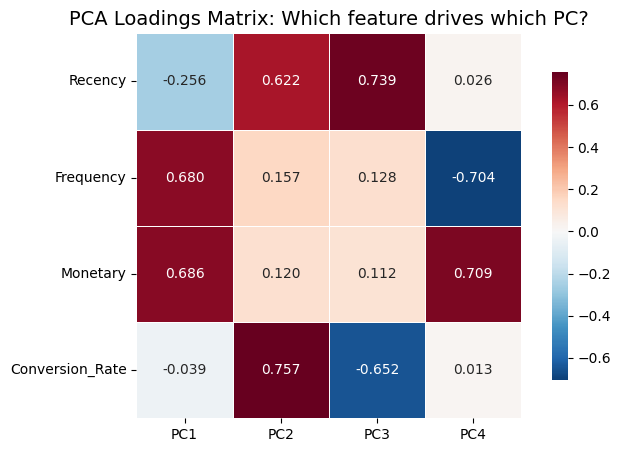

In [30]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3', 'PC4'], 
    index=cols_to_use
)
plt.figure(figsize=(8, 5))

sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.3f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('PCA Loadings Matrix: Which feature drives which PC?', fontsize=14)
plt.yticks(rotation=0) 
plt.show()

PC1 (rục Sức Mạnh Mua Sắm - Overall Value): cao Khách VIP, thấp Khách mới/giá trị thấp

PC2 (Trục Khách Cũ Hiệu Quả - Efficient Dormancy): One-hit Wonders chốt đơn nhanh (Conversion cao) nhưng lặn lâu (dùng quen items, thường mua luôn khi cần)

PC3 (Trục Rời Bỏ - Churn Risk): Khách hàng đã mất/ rời bỏ

PC4 (Trục Phong Cách Chi Tiêu - Shopping Behavior): 
PC4 Dương: M cao, F thấp  Người săn hàng hiệu / Mua sỉ
PC4 Âm   : M thấp, F cao  Người mua lặt vặt, nhu cầu txuyen

## 3. K-means

In [31]:
# wcss = []                # Inertia (Elbow) – càng nhỏ càng tốt
# silhouette_avg = []      # Silhouette – càng lớn càng tốt
# k_range = range(2, 11)

# print("Đang chạy thử nghiệm tìm K tối ưu...")

# # -----------------------------
# # Training loop
# # -----------------------------
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    
#     labels = kmeans.fit_predict(X_pca)
#     # Elbow metric
#     wcss.append(kmeans.inertia_)
#     # Silhouette metric
#     score = silhouette_score(X_pca, labels)
#     silhouette_avg.append(score)
    
#     print(f"k={k}: Inertia = {kmeans.inertia_:.0f} | Silhouette = {score:.4f}")

# # -----------------------------
# # Plot: Dual-axis (1 plot)
# # -----------------------------
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Trục trái – Inertia (WCSS)
# ax1.set_xlabel('Số lượng cụm (k)', fontsize=12)
# ax1.set_ylabel('Inertia (WCSS) – Thấp hơn là tốt', fontsize=12)
# ax1.plot(
#     k_range, wcss,
#     marker='o',
#     linestyle='-',
#     linewidth=2,
#     label='Inertia'
# )
# ax1.set_xticks(list(k_range))
# ax1.grid(True, axis='x', linestyle='--', alpha=0.4)

# # Trục phải – Silhouette Score
# ax2 = ax1.twinx()
# ax2.set_ylabel('Silhouette Score – Cao hơn là tốt', fontsize=12)
# ax2.plot(
#     k_range, silhouette_avg,
#     marker='s',
#     linestyle='--',
#     linewidth=2,
#     label='Silhouette'
# )

# # Title
# plt.title(
#     'Phân tích chọn K: Elbow Method vs. Silhouette Score',
#     fontsize=16,
#     fontweight='bold'
# )
# # Highlight potential optimal k values
# plt.axvline(x=4, linestyle='--', alpha=0.6, label='k = 4')
# plt.axvline(x=5, linestyle='--', alpha=0.6, label='k = 5')
# plt.legend()
# fig.tight_layout()
# plt.show()
# # 

--- CLUSTER PROFILES (Average Values) ---


,Cluster,Recency,Frequency,Monetary,Conversion_Rate,Count,Percent
0,0,-0.10,1.88,0.60,0.02,2526,21.8
1,1,-0.60,-0.52,-0.27,-0.97,2706,23.4
2,2,-0.64,-0.53,0.14,0.74,2804,24.2
3,3,1.04,-0.53,-0.34,0.14,3533,30.5


<class 'sklearn.decomposition._pca.PCA'>

--- PCA COORDINATES PER CLUSTER ---


,PC1,PC2
Cluster,,
0,1.72,0.32
1,-0.35,-1.22
2,-0.13,0.10
3,-0.86,0.63


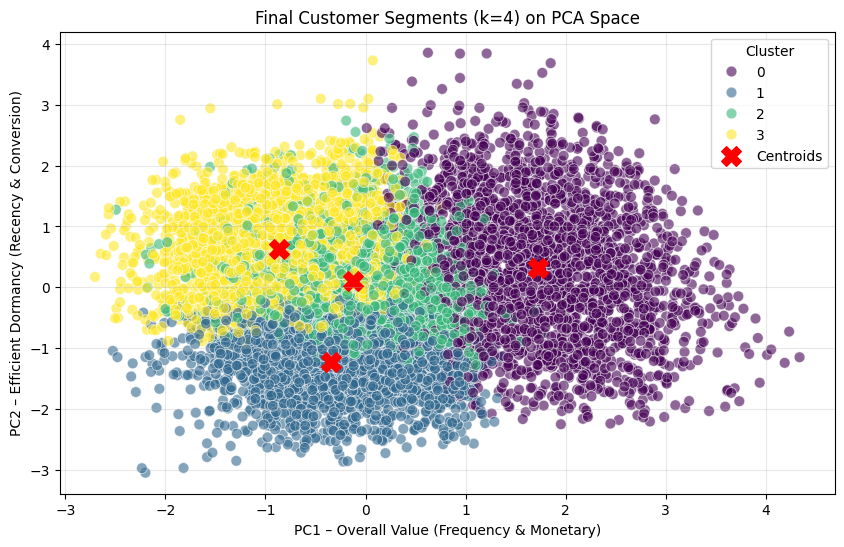

In [32]:
# 1. RUN FINAL K-MEANS WITH K=4
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)

# Fit vào X_pca
cluster_labels = kmeans_final.fit_predict(X_pca)

# Gán label vào X_final
X_final = X_final.copy() # Tạo bản copy để tránh SettingWithCopyWarning
X_final['Cluster'] = cluster_labels


# 2. CLUSTER PROFILING
# Tính trung bình các chỉ số RFM cho từng cụm
cluster_profile = X_final.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']].mean().reset_index()

# Tính số lượng khách hàng trong từng cụm
cluster_size = X_final.groupby('Cluster').size().reset_index(name='Count')

# Gộp bảng và hiển thị
profile_table = cluster_profile.merge(cluster_size, on='Cluster')

# Tính tỷ lệ % cho dễ nhìn (Optional)
profile_table['Percent'] = (profile_table['Count'] / profile_table['Count'].sum() * 100).round(1)

print("--- CLUSTER PROFILES (Average Values) ---")
display(profile_table.round(2))

# 3. VISUALIZE THE SEGMENTS
print(type(pca))

# Giả sử X_pca đang là numpy array (output chuẩn của sklearn)
# Tạo tên cột PC1, PC2, PC3... dựa trên số chiều của X_pca
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]

# Tạo DataFrame X_pca_df với index khớp với X_final để không bị lệch dòng
X_pca_df = pd.DataFrame(X_pca, columns=pc_columns, index=X_final.index)

# Thêm cột Cluster vào X_pca_df để vẽ
X_pca_df['Cluster'] = X_final['Cluster']

# --- A. Xem trung bình tọa độ PCA của từng cụm ---
print("\n--- PCA COORDINATES PER CLUSTER ---")
pca_profile = X_pca_df.groupby('Cluster')[['PC1', 'PC2']].mean() # Chỉ cần xem PC1, PC2 là chính
display(pca_profile.round(2))

# --- B. Vẽ biểu đồ Scatter Plot ---
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=X_pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    alpha=0.6,
    s=60 # Kích thước điểm
)

# Vẽ tâm cụm (Centroids) lên biểu đồ cho chuyên nghiệp hơn
centroids = kmeans_final.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

plt.title('Final Customer Segments (k=4) on PCA Space')
plt.xlabel('PC1 – Overall Value (Frequency & Monetary)') # Đặt tên theo ý nghĩa bạn đã phân tích
plt.ylabel('PC2 – Efficient Dormancy (Recency & Conversion)') # Đặt tên theo ý nghĩa bạn đã phân tích
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()


## 4. Profile & Name

In [36]:
# 4. BUSINESS MAPPING & MERGING (CUSTOM SEGMENTS)

segment_names = {
    0: 'Loyal Customers',       # F cao, M cao: Khách trung thành
    1: 'Window Shoppers',       # R tốt, CR thấp: Chỉ xem, ít mua
    2: 'Promising / New',       # R tốt, CR cao: Mới mua, chốt đơn tốt
    3: 'Lost / Hibernating'     # R xấu (cao): Lâu không quay lại
}

# Map vào DataFrame chính
X_final['Segment'] = X_final['Cluster'].map(segment_names)

# =========================================================
# 5. FINAL REPORT
# =========================================================
# Tính lại chỉ số trung bình theo tên Segment mới để báo cáo
final_report = (
    X_final
    .groupby('Segment')[['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']]
    .mean()
    .round(2)
)

# Thêm cột số lượng khách
segment_counts = X_final['Segment'].value_counts()
final_report['Count'] = segment_counts

print("--- FINAL CUSTOMER SEGMENTATION PROFILES ---")
# Tô màu: Recency thấp là tốt (xanh), cao là xấu. Các chỉ số khác cao là tốt.
from matplotlib.colors import LinearSegmentedColormap

# 1. Tạo dải màu tùy chỉnh: Xám (nhỏ) -> Vàng (trung) -> Xanh (lớn)
# Mã màu này là tông Pastel sáng, rất dịu mắt
my_cmap = LinearSegmentedColormap.from_list("MyLightPalette", ["#f0f0f0", "#fff176", "#81c784"])

# 2. Hiển thị (Thay thế dòng display cũ của bạn)
display(final_report.style.background_gradient(
    cmap=my_cmap, 
    subset=['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']
).format("{:.2f}")) # Format luôn 2 số thập phân cho gọn

--- FINAL CUSTOMER SEGMENTATION PROFILES ---


,Recency,Frequency,Monetary,Conversion_Rate,Count
Segment,,,,,
Lost / Hibernating,1.04,-0.53,-0.34,0.14,3533.00
Loyal Customers,-0.10,1.88,0.60,0.02,2526.00
Promising / New,-0.64,-0.53,0.14,0.74,2804.00
Window Shoppers,-0.60,-0.52,-0.27,-0.97,2706.00


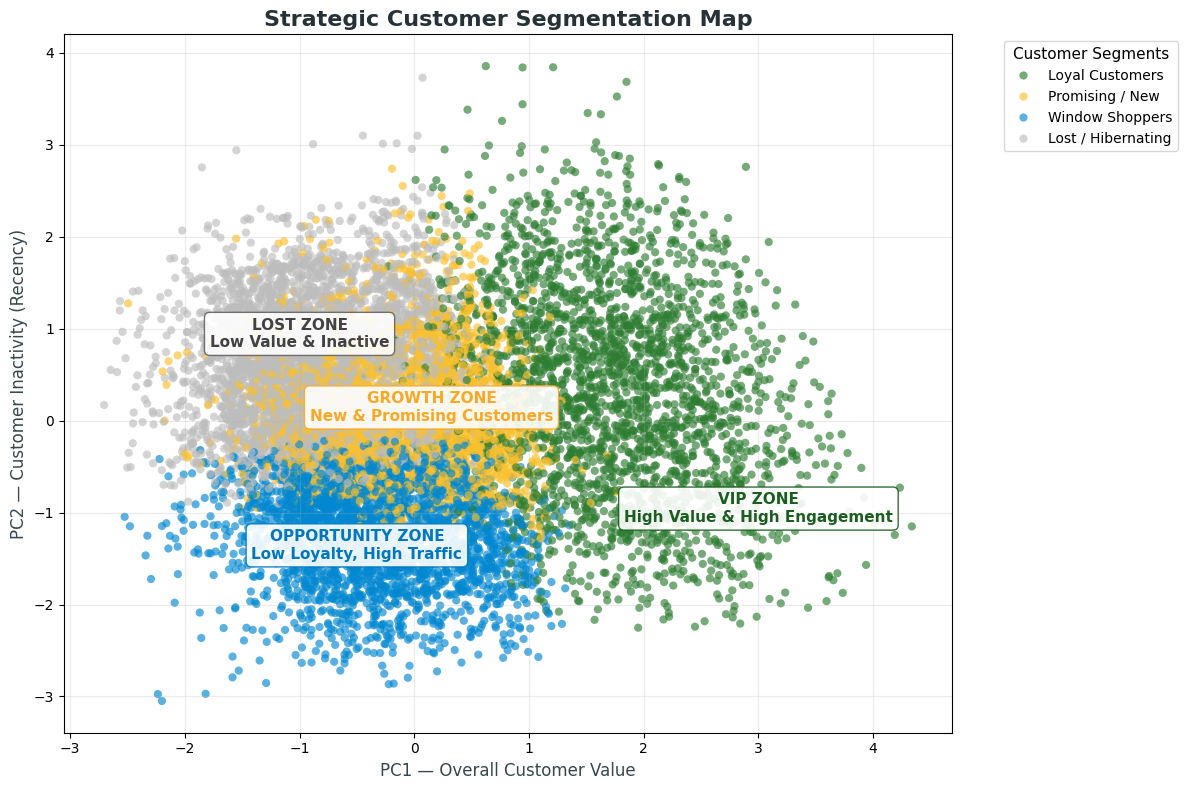

In [46]:
# =========================================================
# 6. PLOT FINAL STRATEGIC CHART
# =========================================================
plt.figure(figsize=(12, 8))

# Business-meaning color palette
custom_palette = {
    'Loyal Customers': '#2E7D32',        # Dark green
    'Window Shoppers': '#0288D1',        # Blue
    'Promising / New': '#FBC02D',        # Gold (less harsh than pure yellow)
    'Lost / Hibernating': '#BDBDBD'      # Neutral gray
}

sns.scatterplot(
    data=X_pca_df,
    x='PC1',
    y='PC2',
    hue=X_final['Segment'],
    palette=custom_palette,
    alpha=0.65,
    s=35,
    edgecolor='none'
)

# Titles & labels
plt.title(
    'Strategic Customer Segmentation Map',
    fontsize=16,
    fontweight='bold',
    color='#263238'
)
plt.xlabel(
    'PC1 — Overall Customer Value',
    fontsize=12,
    color='#37474F'
)
plt.ylabel(
    'PC2 — Customer Inactivity (Recency)',
    fontsize=12,
    color='#37474F'
)

# Legend styling
plt.legend(
    title='Customer Segments',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True
)

plt.grid(True, alpha=0.25)

# Clear, high-contrast annotations (placed outside dense clusters)
# Strategic zone annotations (4 segments)

plt.text(
    x=3.0,
    y=-1.1,
    s="VIP ZONE\nHigh Value & High Engagement",
    fontsize=11,
    fontweight='bold',
    color='#1B5E20',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#1B5E20', alpha=0.9)
)

plt.text(
    x=0.15,
    y= 0,
    s="GROWTH ZONE\nNew & Promising Customers",
    fontsize=11,
    fontweight='bold',
    color='#F9A825',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#F9A825', alpha=0.9)
)

plt.text(
    x=-0.5,
    y=-1.5,
    s="OPPORTUNITY ZONE\nLow Loyalty, High Traffic",
    fontsize=11,
    fontweight='bold',
    color='#0277BD',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#0277BD', alpha=0.9)
)

plt.text(
    x=-1,
    y=0.8,
    s="LOST ZONE\nLow Value & Inactive",
    fontsize=11,
    fontweight='bold',
    color='#424242',
    ha='center',
    bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='#616161', alpha=0.9)
)


plt.tight_layout()
plt.show()